# Make maps

Script for making maps

In [1]:
import timm
import json
import os
import torch
import pandas as pd
import numpy as np
import configparser
from tqdm import tqdm
from huggingface_hub import hf_hub_download
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde

sns.set(style="whitegrid")

tqdm.pandas()

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read config file
config = configparser.ConfigParser()
config.read('../config.ini')

DATA_DIR = config['PATHS']['DATA_DIR']

# Set up PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_float32_matmul_precision("high")

# Set seeds for reproducibility
RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# Define the directory for end-to-end models
MODELS_DIR = os.path.join(DATA_DIR, 'models', 'mse_num_top_epochs=0_num_full_epochs=20')
if not os.path.exists(MODELS_DIR):
    raise FileNotFoundError(f"Models directory not found at {MODELS_DIR}")

folds = ['A', 'B', 'C', 'D', 'E']

# Load the dataset with predictions
df = pd.read_csv(os.path.join(MODELS_DIR, 'dhs_with_imgs_predictions.csv'))
with open(os.path.join(MODELS_DIR, 'correction_values.json'), 'r') as f:
    correction_values = json.load(f)

In [3]:
df.groupby('region_id').mean()

,lon,lat,rural,month,year,iwi,iwi_hat,train_score,val_score
region_id,,,,,,,,,
AO.Bengo,13.908061,-8.435568,0.636364,5.575758,2015.575758,34.948254,31.057923,-0.005341,-0.000025
AO.Benguela,13.858086,-12.736620,0.363636,8.303030,2015.272727,34.467082,38.960760,-0.007805,-0.005297
AO.Bié,17.012872,-12.007002,0.625000,4.406250,2015.687500,22.730280,25.265740,0.029448,0.043404
AO.Cabinda,12.254070,-5.477956,0.181818,5.212121,2015.636364,60.380207,56.435070,-0.042244,-0.048862
AO.Cuando Cubango,18.608551,-15.454207,0.484848,4.848485,2015.666667,25.197943,27.614106,0.044026,0.051065
...,...,...,...,...,...,...,...,...,...
ZW.Matabeleland North,27.655321,-18.835474,0.775281,8.101124,2010.157303,24.828918,24.588807,0.000828,0.013781
ZW.Matabeleland South,28.904847,-21.066943,0.804598,8.494253,2009.816092,26.977507,24.926965,-0.002572,0.009375
ZW.Matebeleland North,27.706581,-18.847011,0.900000,6.533333,2005.300000,14.647692,22.478565,-0.001843,0.014681


In [4]:
import fiona
import shapely.geometry
from shapely.geometry import shape, Point
import pandas as pd
from rtree import index
import math

exp_dir = os.path.join(DATA_DIR, 'cindy_experiments')

shapes = []
properties = []
with fiona.open(os.path.join(exp_dir, 'data/country_regions/gadm2_clean.shp')) as shp:
    for feature in tqdm(shp):
        geom = shape(feature['geometry'])
        shapes.append(geom)
        properties.append(feature['properties'])

100%|██████████| 47041/47041 [00:57<00:00, 818.39it/s] 


In [5]:
import geopandas as gpd
gdf = gpd.GeoDataFrame(properties, geometry=shapes)

african_iso3_codes = [
    "DZA", "AGO", "BEN", "BWA", "BFA", "BDI", "CPV", "CMR", "CAF", "TCD", "COM",
    "COG", "COD", "DJI", "EGY", "GNQ", "ERI", "SWZ", "ETH", "GAB", "GMB", "GHA",
    "GIN", "GNB", "CIV", "KEN", "LSO", "LBR", "LBY", "MDG", "MWI", "MLI", "MRT",
    "MUS", "MAR", "MOZ", "NAM", "NER", "NGA", "RWA", "STP", "SEN", "SYC", "SLE",
    "SOM", "ZAF", "SSD", "SDN", "TZA", "TGO", "TUN", "UGA", "ZMB", "ZWE", "ESH"
]


africa_gdf = gdf[gdf['ISO'].isin(african_iso3_codes)].reset_index(drop=True)

africa_gdf

,ID_adm2,ISO,part_area,geometry
0,c118r10r56,KEN,4314.533876,"POLYGON ((36.79758 -2.55378, 36.79652 -2.55324..."
1,c118r10r57,KEN,3268.699270,"POLYGON ((37.67785 -2.25568, 37.67780 -2.25577..."
2,c118r10r58,KEN,112.345759,"POLYGON ((36.78143 -1.38591, 36.78157 -1.38597..."
3,c118r10r59,KEN,6357.609501,"POLYGON ((37.85370 -3.16922, 37.85369 -3.16931..."
4,c118r10r60,KEN,7940.396335,"POLYGON ((36.67472 -1.74086, 36.67267 -1.75022..."
...,...,...,...,...
6133,c97r8r30,GIN,4236.501539,"POLYGON ((-10.40708 8.45314, -10.40715 8.45300..."
6134,c97r8r31,GIN,4476.916810,"POLYGON ((-8.47218 7.55458, -8.48715 7.57121, ..."
6135,c97r8r32,GIN,8055.817327,"POLYGON ((-9.16320 7.93243, -9.17117 7.92128, ..."
6136,c97r8r33,GIN,4054.517644,"POLYGON ((-8.72145 7.49459, -8.72686 7.48956, ..."


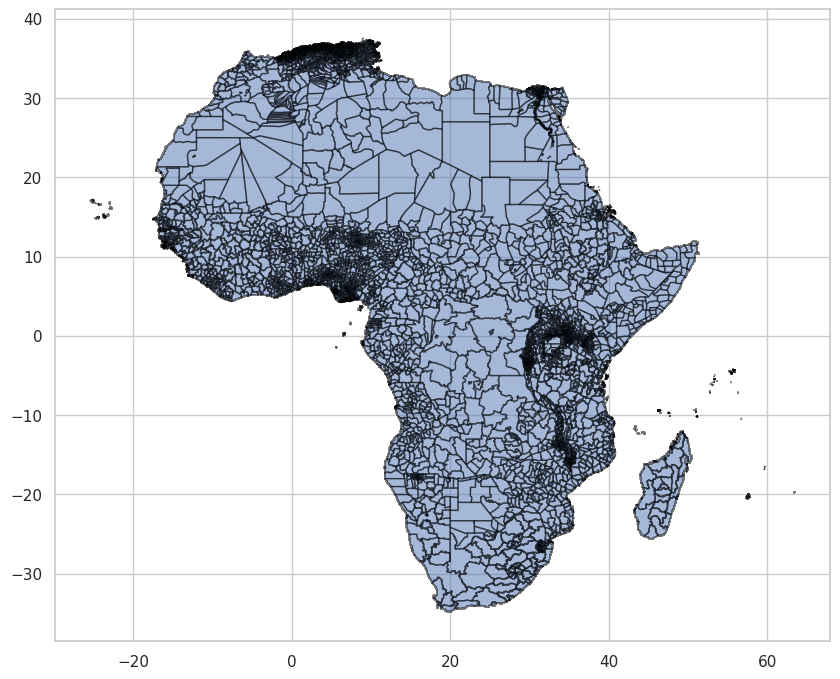

In [6]:
africa_gdf.plot(figsize=(10, 10), edgecolor='black', alpha=0.5)
plt.show()

In [7]:
idx = index.Index()
for i, geom in enumerate(shapes):
    idx.insert(i, geom.bounds)

In [8]:
def find_region(lat, lon):
    point = Point(lon, lat)

    # Try to find containing polygon
    candidates = list(idx.intersection((lon, lat, lon, lat)))
    for i in candidates:
        if shapes[i].contains(point):
            return properties[i]  # return ADM2 properties

    # If not found, find the nearest polygon
    min_dist = math.inf
    nearest_i = None
    for i in idx.nearest((lon, lat, lon, lat), 5):  # Try 5 nearest first
        dist = point.distance(shapes[i])
        if dist < min_dist:
            min_dist = dist
            nearest_i = i
    return properties[nearest_i] if nearest_i is not None else None

In [9]:
df['ID_adm2'] = df.progress_apply(lambda row: find_region(row['lat'], row['lon']).get('ID_adm2'), axis=1)

100%|██████████| 68619/68619 [04:59<00:00, 229.18it/s] 


In [10]:
df['residual'] = df['iwi_hat'] - df['iwi']
df['tweedie_correction'] = df.apply(lambda row: -(correction_values[row['cv_fold']]['train_sigma'] ** 2) * row['train_score'], axis=1)
adm2_df = df.groupby('ID_adm2').mean()
adm2_df

,lon,lat,rural,month,year,iwi,iwi_hat,train_score,val_score,residual,tweedie_correction
ID_adm2,,,,,,,,,,,
c118r10r56,36.810456,-2.131263,0.769231,6.153846,2016.076923,30.075351,23.799800,0.012313,0.028063,-6.275551,-0.367316
c118r10r57,36.982422,-1.603496,0.318182,6.636364,2018.363636,45.327017,41.576794,-0.006996,-0.008488,-3.750223,0.328050
c118r10r58,36.721241,-1.391484,0.115385,5.038462,2016.115385,49.245733,48.154164,-0.013590,-0.021129,-1.091568,0.434650
c118r10r59,37.502894,-2.800207,0.846154,7.000000,2016.230769,26.780810,25.456734,-0.015568,-0.006762,-1.324076,0.496354
c118r10r60,36.399009,-1.583137,0.785714,6.428571,2018.714286,22.869641,26.297177,0.020518,0.028499,3.427536,-0.466179
...,...,...,...,...,...,...,...,...,...,...,...
c97r8r30,-10.283874,8.606118,0.739130,5.869565,2009.500000,19.700926,18.707890,0.043335,0.058407,-0.993036,-1.503752
c97r8r31,-8.431906,7.884612,0.800000,6.200000,2011.500000,22.068867,21.612134,0.041695,0.053342,-0.456733,-1.117235
c97r8r32,-9.353269,8.407812,0.777778,6.083333,2009.333333,18.891819,20.739335,0.021505,0.036973,1.847516,-0.734469


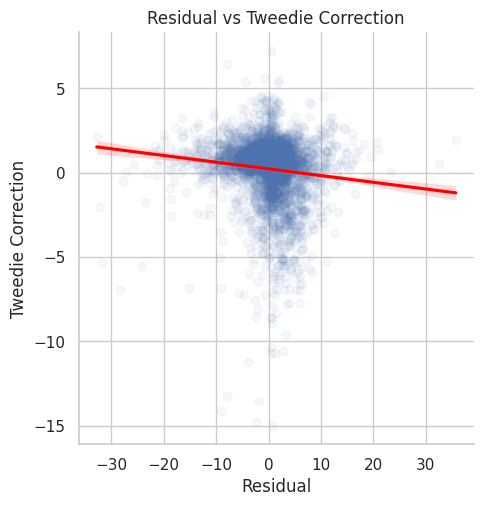

In [13]:
#plt.scatter(adm2_df['residual'], adm2_df['tweedie_correction'], alpha=0.05)
sns.lmplot(adm2_df, x='residual', y='tweedie_correction', scatter_kws={'alpha': 0.05}, line_kws={'color': 'red'})
plt.xlabel('Residual')
plt.ylabel('Tweedie Correction')
plt.title('Residual vs Tweedie Correction')
plt.show()

Get an outline to improve the map plots

In [ ]:
from shapely.geometry import MultiPolygon

africa_outline = africa_gdf.dissolve()  # dissolve all into one geometry

# Step 2: Explode into individual polygons
outline_parts = africa_outline.explode(index_parts=False)

# Step 3: Filter by area (e.g., keep polygons > some threshold)
area_threshold = 1e1  # Adjust as needed (in square meters if CRS is meters)
outline_filtered = outline_parts[outline_parts.area > area_threshold]

# Step 4: Recombine into one MultiPolygon
filtered_geom = outline_filtered.unary_union
if isinstance(filtered_geom, MultiPolygon):
    filtered_outline_gdf = gpd.GeoDataFrame(geometry=[filtered_geom], crs=africa_gdf.crs)
else:
    filtered_outline_gdf = gpd.GeoDataFrame(geometry=[filtered_geom], crs=africa_gdf.crs)

simplified_outline = filtered_outline_gdf.copy()
simplified_outline['geometry'] = simplified_outline.simplify(tolerance=0.2, preserve_topology=True)

simplified_outline.boundary.plot(edgecolor='black', linewidth=0.5)
plt.show()

/local/tmp.4788640/ipykernel_3109413/3554905329.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


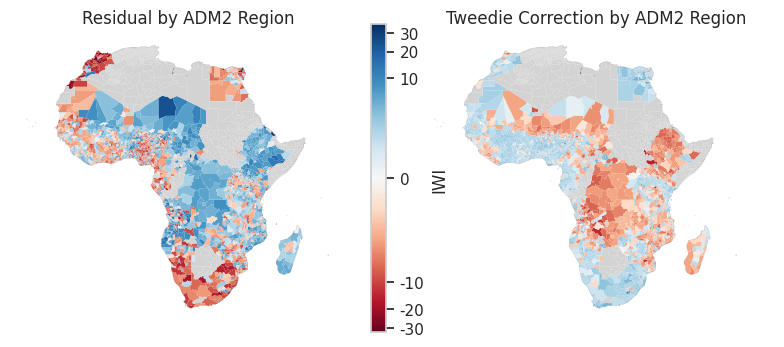

In [67]:
import numpy as np
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import FixedLocator, FixedFormatter

# Define transformation
def signed_cuberoot(x):
    return np.sign(x) * np.abs(x)**(1/3)

# Inverse transformation (for labeling)
def inv_signed_cuberoot(x):
    return np.sign(x) * np.abs(x)**3

# Transform data
for col in ['residual', 'tweedie_correction']:
    plot_gdf[f'{col}_transformed'] = signed_cuberoot(plot_gdf[col])

columns = ['residual_transformed', 'tweedie_correction_transformed']

# Set common color scale based on transformed data
vmin = min(plot_gdf[columns].min())
vmax = max(plot_gdf[columns].max())
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
cmap = 'RdBu'

for ax, column, title in zip(axes, columns, ['Residual by ADM2 Region', 'Tweedie Correction by ADM2 Region']):
    plot_gdf.plot(
        column=column,
        cmap=cmap,
        ax=ax,
        edgecolor='none',
        norm=norm,
        legend=False,
        missing_kwds={
            'color': 'lightgray',
            'label': 'Missing data'
        }
    )
    ax.set_title(title)
    simplified_outline.boundary.plot(ax=ax, edgecolor='black', linewidth=0.05)
    ax.axis('off')

# Add shared colorbar with original IWI scale labels
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []

# Choose original-scale ticks (e.g., in IWI or raw residual units)
iwi_tick_labels = [-30, -20, -10, 0, 10, 20, 30]  # you can modify this range
transformed_ticks = [signed_cuberoot(x) for x in iwi_tick_labels]

cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.55, pad=0.05)
cbar.set_label('IWI')
cbar.set_ticks(transformed_ticks)
cbar.set_ticklabels(iwi_tick_labels)

# Show and save
plt.tight_layout()
plt.savefig(os.path.join(MODELS_DIR, 'res_and_tweedie_by_adm2_labeled.png'), dpi=300, bbox_inches='tight')
plt.show()


/local/tmp.4788640/ipykernel_3109413/1666694174.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


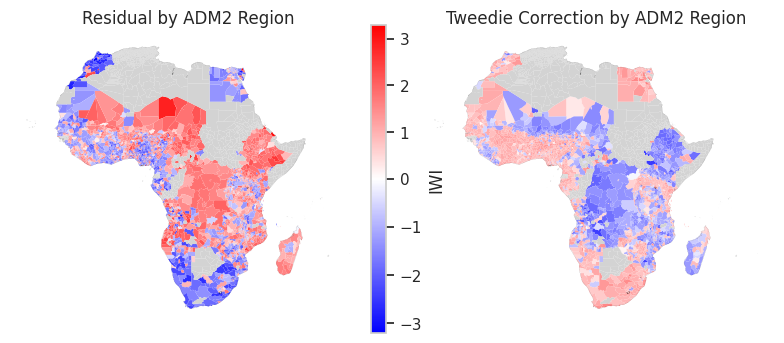

In [63]:
from matplotlib.colors import TwoSlopeNorm

# Merge with Africa GeoDataFrame
plot_gdf = africa_gdf.merge(adm2_df, left_on='ID_adm2', right_index=True, how='left')

# africa_outline = africa_gdf.dissolve()  # dissolve all into one geometry

# Clip residuals and corrections to the range [-20, 20]
# plot_gdf['residual'] = plot_gdf['residual'].clip(-15, 15)

# Apply signed cube root transformation
def signed_cuberoot(x):
    return np.sign(x) * np.abs(x)**(1/3)

# Apply the transformation
for col in ['residual', 'tweedie_correction']:
    plot_gdf[f'{col}_transformed'] = signed_cuberoot(plot_gdf[col])

columns = ['residual_transformed', 'tweedie_correction_transformed']

# Determine global min/max for color scaling
#columns = ['residual', 'tweedie_correction']
vmin = min(plot_gdf[columns].min())
vmax = max(plot_gdf[columns].max())

# Ensure color scale is centered at 0
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
cmap = 'bwr'

# Plot each column with the same color scale
for ax, column, title in zip(axes, columns, ['Residual by ADM2 Region', 'Tweedie Correction by ADM2 Region']):
    plot_gdf.plot(
        column=column,
        cmap=cmap,
        ax=ax,
        edgecolor='none',
        norm=norm,
        legend=False,
        missing_kwds={
            'color': 'lightgray',
            'label': 'Missing data'
        }
    )
    ax.set_title(title)
    simplified_outline.boundary.plot(ax=ax, edgecolor='black', linewidth=0.05)
    ax.axis('off')

# Add a shared colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  # For compatibility with older matplotlib versions
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.55)
cbar.set_label('IWI')

# Save and show the figure
plt.tight_layout()
plt.savefig(os.path.join(MODELS_DIR, 'res_and_tweedie_by_adm2.png'), dpi=300, bbox_inches='tight')
plt.show()


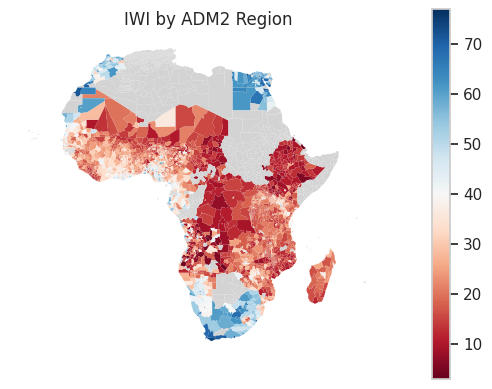

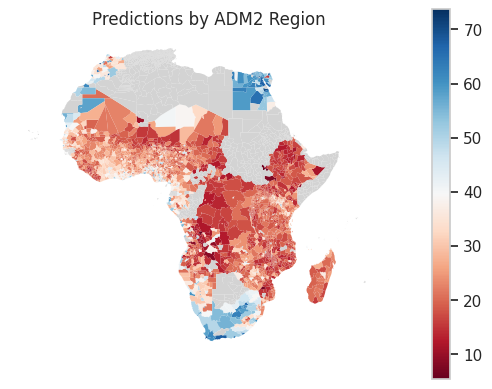

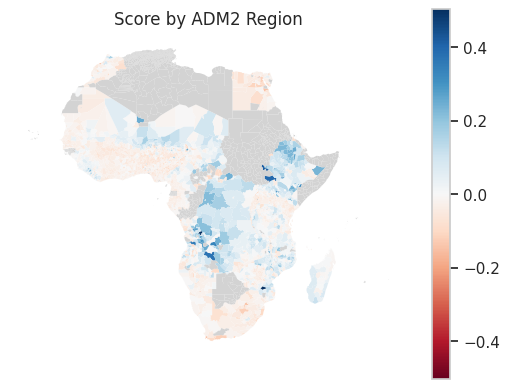

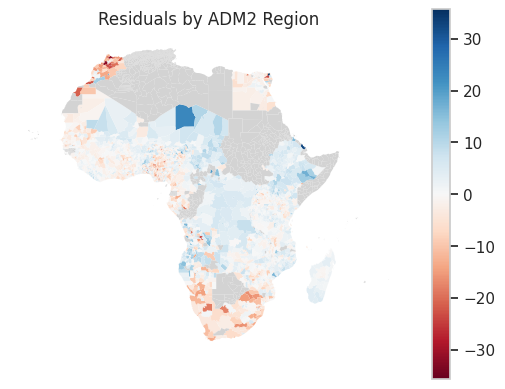

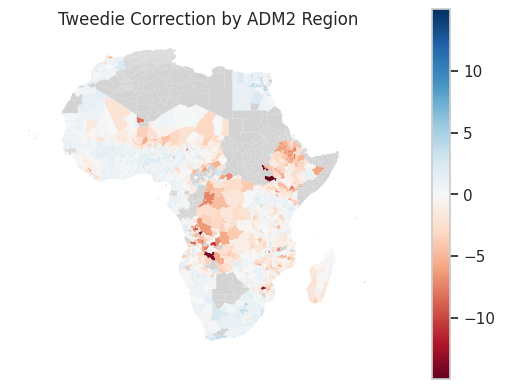

In [19]:
# Merge with Africa GeoDataFrame
plot_gdf = africa_gdf.merge(adm2_df, left_on='ID_adm2', right_index=True, how='left')

def plot_map(gdf, column, title, center_on_zero=False, save_path=None):


    # Compute symmetric limits around 0
    if center_on_zero:
        values = gdf[column]
        abs_max = np.nanmax(np.abs(values))

    gdf.plot(
        column=column,
        cmap='RdBu',
        legend=True,
        edgecolor='none',         # Remove edges
        vmin=-abs_max if center_on_zero else None,
        vmax=abs_max if center_on_zero else None,
        missing_kwds={            # Handle NaNs
            'color': 'lightgray',
            'label': 'Missing data'
        }
    )
    plt.title(title)
    plt.axis('off')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

plot_map(plot_gdf, 'iwi', 'IWI by ADM2 Region', save_path=os.path.join(MODELS_DIR, 'iwi_by_adm2.png'))
plot_map(plot_gdf, 'iwi_hat', 'Predictions by ADM2 Region', save_path=os.path.join(MODELS_DIR, 'predictions_by_adm2.png'))
plot_map(plot_gdf, 'train_score', 'Score by ADM2 Region', center_on_zero=True, save_path=os.path.join(MODELS_DIR, 'score_by_adm2.png'))
plot_map(plot_gdf, 'residual', 'Residuals by ADM2 Region', center_on_zero=True, save_path=os.path.join(MODELS_DIR, 'residuals_by_adm2.png'))
plot_map(plot_gdf, 'tweedie_correction', 'Tweedie Correction by ADM2 Region', center_on_zero=True, save_path=os.path.join(MODELS_DIR, 'tweedie_correction_by_adm2.png'))